In [8]:
#! usr/bin/env python3
"""
assess cluster-wise stability of hierarchical clustering results
using boot striping and Jaccard index
Using linear assignment problem algorithm, a variation of stable marriage problem
"""
import numpy as np
from scipy.optimize import linear_sum_assignment
import pandas as pd

from SupertypeTools import hierarchical_cluster

def jaccard(member_index1:list, member_index2:list) -> float:
    # calculate jaccard index between two groups
    s1 = set(member_index1)
    s2 = set(member_index2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

def max_jaccard(clustering1:np.array, clustering2:np.array):
    """
    since cluster name might change, max jaccard is used to indicate matching cluster between
    reference clustering (full sample) and bootstrap clustering
    """
    groups1 = np.unique(clustering1) # name of groups
    groups2 = np.unique(clustering2)
    jar_matrix = np.zeros((len(groups1),len(groups2))) # jaccard index matrix, storing jaccard index of all-to-all groups

    for i in range(len(groups1)):
        for j in range(len(groups2)):
            members1 = np.where(clustering1 == i)[0] # index of group members
            members2 = np.where(clustering2 == j)[0]
            jar_matrix[i,j] = jaccard(members1, members2)

    row_idx, col_idx = linear_sum_assignment(jar_matrix, maximize=True) # find the solution with maximum sum
    # print(jar_matrix, row_ind, col_ind)
    # print(groups1[row_ind])
    return row_idx, jar_matrix[row_idx, col_idx]

def bootstrap_sampling(sample_size:int, nb):
    """
    return index of samples
    """
    samples_idx = []
    idx = [i for i in range(sample_size)]
    for _ in range(nb):
        x = np.random.choice(idx, sample_size, replace=True).tolist()
        samples_idx.append(x)

    return samples_idx

def cluster_stability(dist_mat:pd.DataFrame, ref_clustering:pd.Series, NB, N_cluster=None, threshold=None, average=True)->np.array:
    """
    returns average/step-wise jaccard index (similarity) of each cluster
    """
    # distance matrix is upper-triangle, change to square form
    dist_mat = dist_mat.add(dist_mat.T, fill_value=0)
    dist_mat = dist_mat.to_numpy()

    ref_groups = np.unique(ref_clustering)
    N_groups = len(ref_groups)
    N_samples = dist_mat.shape[0]

    jac_matrix = np.empty((NB, N_groups))
    jac_matrix[:] = np.nan
    bt_index = bootstrap_sampling(N_samples, NB)
    for i in range(NB):
        index = bt_index[i]
        dist_mat_bt = dist_mat[:,index][index,:]
        dist_mat_bt = pd.DataFrame(dist_mat_bt)
        ref_group = ref_clustering[index]

        bt_group, _ = hierarchical_cluster(dist_mat_bt, square=True, N=N_cluster, threshold=threshold)

        group_idx, group_jac = max_jaccard(ref_group, bt_group)

        jac_matrix[i, group_idx] = group_jac
        # for idx, jac in zip(group_idx, group_jac):
        #     jac_matrix[i, idx] = jac
    # print(jac_matrix)
    # print(np.mean(jac_matrix, axis=0))
    if average:
        return np.mean(jac_matrix, axis=0)

    else:
        return jac_matrix

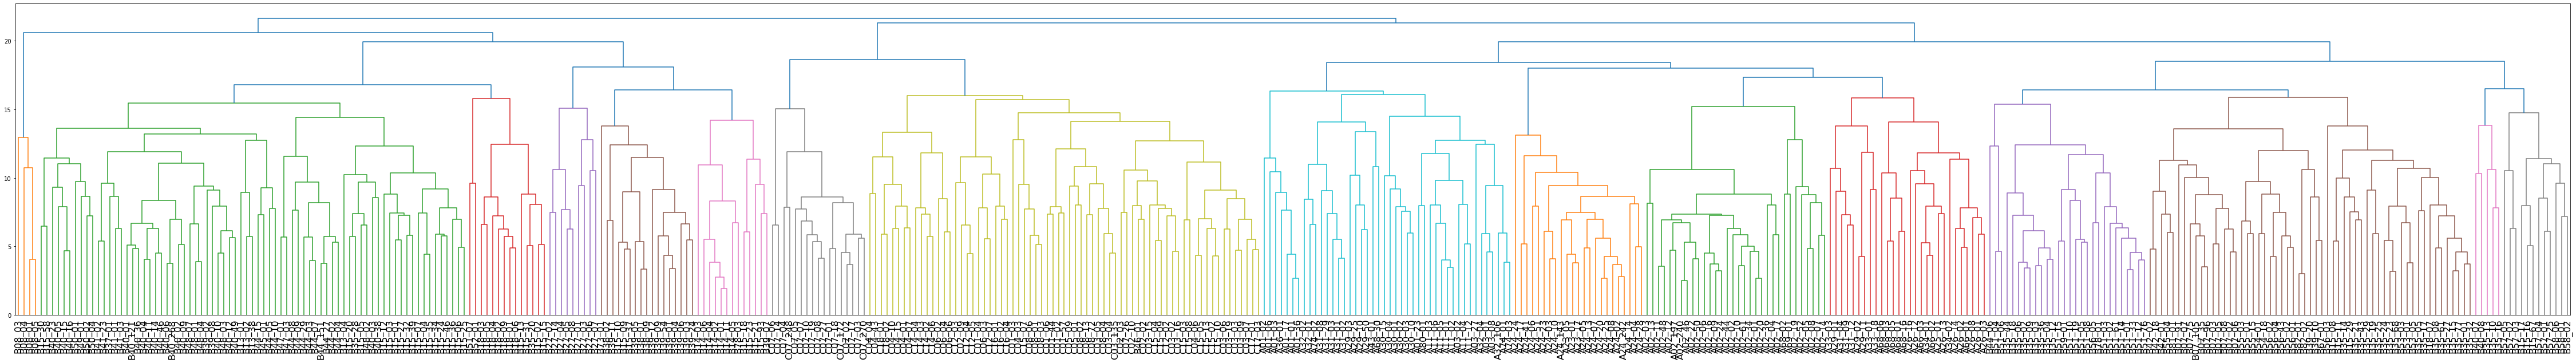

In [3]:
Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
cluster, order = hierarchical_cluster(Mat, N=16, L='complete', color_threshold=16.4, plot_dendro=True, outtree="Fig4-24.newick")
# L choose from ['complete', 'average', 'single']

In [15]:
stab = cluster_stability(Mat, cluster, 100, N_cluster=16, average=False)

In [16]:
np.nanmean(stab,axis=0)

array([0.39114751, 0.77970738, 0.54864375, 0.65728512, 0.57390726,
       0.92023112, 0.86111785, 0.45881222, 0.23229272, 0.963392  ,
       0.71902035, 0.68742324, 0.86449359, 0.31346838, 0.55252587,
       0.79757937])

In [17]:
print(cluster)

A01_01    0
A01_02    0
A01_03    0
A01_06    0
A01_17    0
         ..
C16_04    1
C17_01    1
C17_03    1
C18_01    1
C18_02    1
Length: 447, dtype: int64
